# Microscopie hyperspectrale

Quentin Douzery  
Alexia Ghozland

## 1. Imports

### 1.1. Packages

In [97]:
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
import numpy as np
import os
import math
import pandas as pd
import cv2
import copy

In [98]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.2. Images

In [99]:
#path_dir = "/content/gdrive/My Drive/Hyperspectral" #drive directory
path_dir = "/content/gdrive/My Drive/Hyperspectral/Images-hyperspectrales"
#path_dir = "/home/douzery/Bureau" #local directory

In [103]:
#Dictionnaire qui contient les fichiers des images après segmentation Ilastik
raw_images_names = {"j5_1_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_1_740nm.h5"),
                    "v6_3_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_3_740nm.h5")}

In [109]:
#Dictionnaire qui contient les fichiers des images originales
raw_images_names = {"j5_1_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_1_740nm.h5"),
                    "j5_2_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_2_740nm.h5"),
                    "j5_3_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_3_740nm.h5"),
                    "j5_4_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_4_740nm.h5"),
                    "v6_3_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_3_740nm.h5"),
                    "v6_4_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_4_740nm.h5"),
                    "v6_5_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_5_740nm.h5"),
                    "v6_6_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_6_740nm.h5")}

In [17]:
#Dictionnaire qui contient les fichiers des images après segmentation Ilastik
segmented_images_names = {"j5_1_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_1_740nm_Simple-Segmentation.h5"),
                          "v6_3_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_3_740nm_Simple-Segmentation.h5")}

In [110]:
#Dictionnaire qui contient les fichiers des images originales
segmented_images_names = {"j5_1_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_1_740nm_Simple-Segmentation.h5"),
                          "j5_2_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_2_740nm_Simple-Segmentation.h5"),
                          "j5_3_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_3_740nm_Simple-Segmentation.h5"),
                          "j5_4_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_4_740nm_Simple-Segmentation.h5"),
                          "v6_3_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_3_740nm_Simple-Segmentation.h5"),
                          "v6_4_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_4_740nm_Simple-Segmentation.h5"),
                          "v6_5_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_5_740nm_Simple-Segmentation.h5"),
                          "v6_6_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_6_740nm_Simple-Segmentation.h5")}

In [111]:
#Dictionnaire qui contient les images originales (format hdf5)
aux_raw_images = {}
for name, path in raw_images_names.items():
    aux_raw_images[name] = h5py.File(path, 'r')

In [112]:
#Dictionnaire qui contient les images après segmentation (format hdf5)
aux_segmented_images = {}
for name, path in segmented_images_names.items():
    aux_segmented_images[name] = h5py.File(path, 'r')

In [113]:
#Dictionnaire qui contient les images originales (utilisables, tableau Python)
raw_images = {}
for name, img in tqdm(aux_raw_images.items()):
  z = img['data'].shape[1]
  raw_images[name] = np.reshape(img['data'], (z,512,512,32))

100%|██████████| 8/8 [00:21<00:00,  2.74s/it]


In [114]:
#Dictionnaire qui contient les images après segmentation (utilisables, tableau Python)
segmented_images = {}
for name, img in tqdm(aux_segmented_images.items()):
  z = img['exported_data'].shape[1]
  segmented_images[name] = np.reshape(img['exported_data'], (z,512,512))

100%|██████████| 8/8 [00:00<00:00, 54.49it/s]


## 2. Caractéristiques des images

In [115]:
print("Dimensions d'une image originale (z, y, x, c) :", raw_images["j5_1_740nm"].shape)
print("Dimensions d'une image segmentée (z, y, x) :", segmented_images["j5_1_740nm"].shape)

Dimensions d'une image originale (z, y, x, c) : (12, 512, 512, 32)
Dimensions d'une image segmentée (z, y, x) : (12, 512, 512)


## 3. Pré-traitement

In [116]:
#Création d'un "filtre" pour isoler les valeurs des voxels correspondant à ce qui est du muscle
def Filter_muscle (img):
  z = img.shape[0]
  filter = img - 2*np.ones((z,512,512))
  filter = np.abs(filter)
  return filter

In [47]:
#Création d'un "filtre" pour isoler les valeurs des voxels correspondant à ce qui n'est pas du muscle
def Filter_autre (img):
  z = img.shape[0]
  filter = img - np.ones((z,512,512))
  filter = np.abs(filter)
  return filter

In [117]:
for name, img in tqdm(segmented_images.items()):
  segmented_images[name] = Filter_muscle(img)

100%|██████████| 8/8 [00:00<00:00, 18.15it/s]


## 4. Affichage

In [118]:
image_j = "j5_1_740nm"
image_v = "v6_3_740nm"

### 4.1. Raw images

In [119]:
print("Valeurs des 32 canaux du premier voxel d'une image originale :", raw_images["j5_1_740nm"][0][0][0][:], "\n")

Valeurs des 32 canaux du premier voxel d'une image originale : [173 236 207 191  34 160  45 193 187 247  64  93 312  84 264 204 140 224
 125 180  95 146 130 183 179 120   2 119 261 158 177 119] 



### 4.2. Segmented images

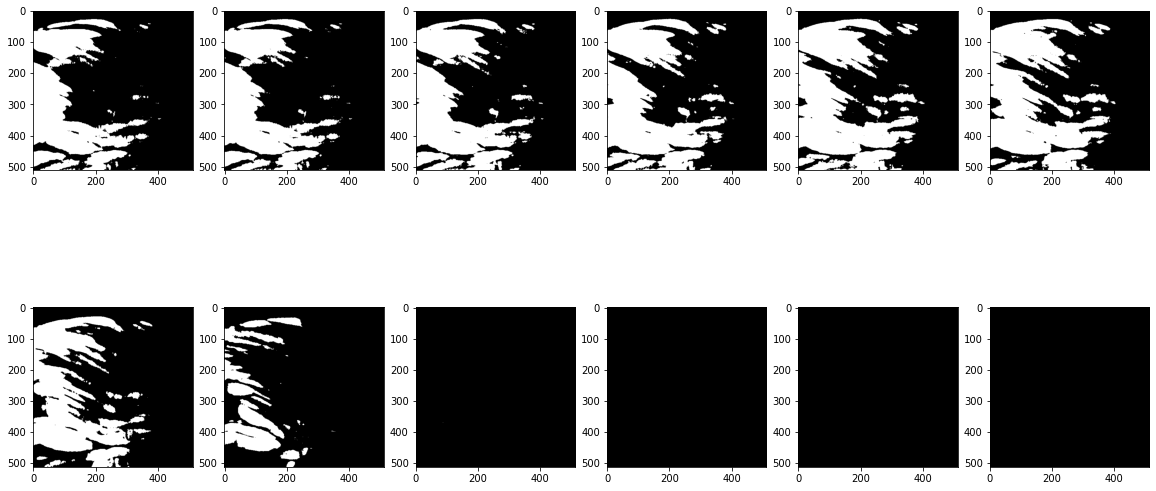

In [120]:
z=0
fig, axs = plt.subplots(2,6, figsize=(20, 10))
for i in range(2):
  for j in range(6):
    Zi = segmented_images[image_j][z,:,:]
    axs[i,j].imshow(Zi, cmap='gray')
    z+=1

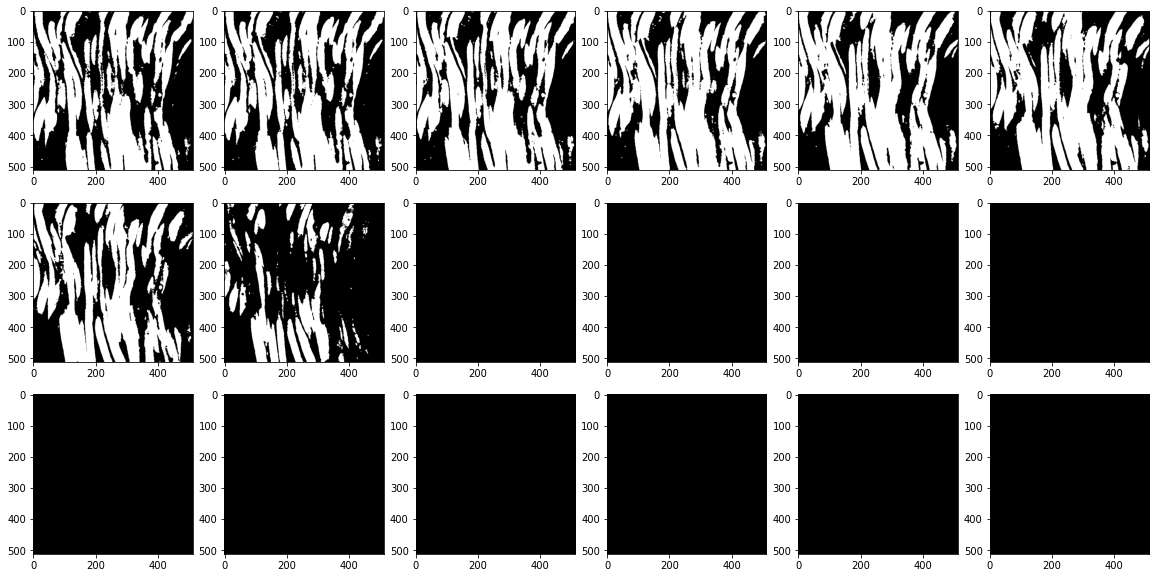

In [121]:
z=0
fig, axs = plt.subplots(3,6, figsize=(20, 10))
for i in range(3):
  for j in range(6):
    Zi = segmented_images[image_v][z,:,:]
    axs[i,j].imshow(Zi, cmap='gray')
    z+=1

## 5. Ouverture

In [122]:
##Création du dictionnaire qui va contenir les images après ouverture
open_segmented_images = copy.deepcopy(segmented_images)

In [123]:
kernel=np.ones((20,20),np.uint8) #kernel rectangulaire
#kernel2=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) #kernel elliptique

In [124]:
for name, img in open_segmented_images.items():
  for z in range(img.shape[0]):
    img[z,:,:] = cv2.morphologyEx(img[z,:,:], cv2.MORPH_OPEN, kernel)

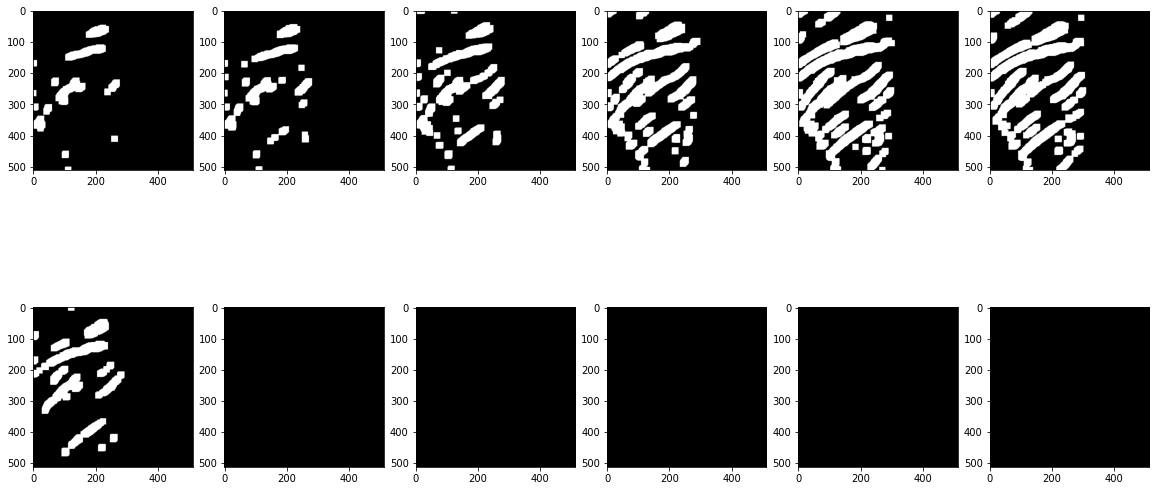

In [125]:
z=0
fig, axs = plt.subplots(2,6, figsize=(20, 10))
for i in range(2):
  for j in range(6):
    Zi = open_segmented_images["j5_2_740nm"][z,:,:]
    axs[i,j].imshow(Zi, cmap='gray')
    z+=1

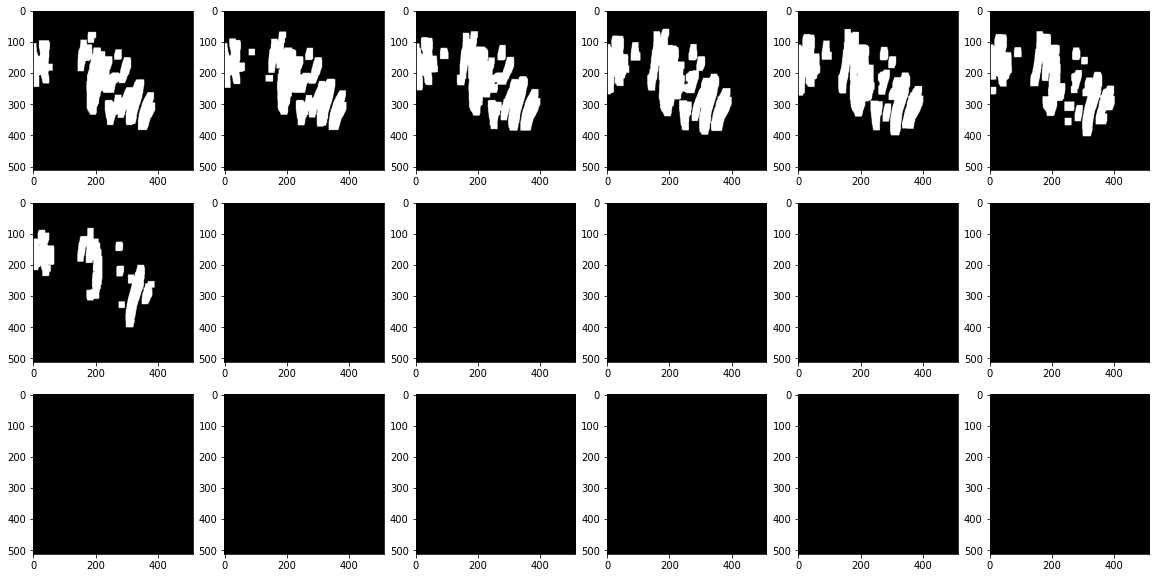

In [126]:
z=0
fig, axs = plt.subplots(3,6, figsize=(20, 10))
for i in range(3):
  for j in range(6):
    Zi = open_segmented_images["v6_4_740nm"][z,:,:]
    axs[i,j].imshow(Zi, cmap='gray')
    z+=1

## 6. Spectres moyens des images

In [127]:
def Mean_spectrum (img, os_img):
  #Utile
  MEAN_SPECTRUM = np.zeros(32) #initialisation du spectre moyen

  #Calcul du spectre moyen
  for i in range(32):
    muscle = os_img*img[:,:,:,i]
    MEAN_SPECTRUM[i] = np.sum(muscle)/np.sum(os_img)

  return MEAN_SPECTRUM

In [128]:
MEAN_SPECTRUM_J1 = Mean_spectrum(raw_images["j5_1_740nm"], open_segmented_images["j5_1_740nm"])
MEAN_SPECTRUM_J2 = Mean_spectrum(raw_images["j5_2_740nm"], open_segmented_images["j5_2_740nm"])
MEAN_SPECTRUM_J3 = Mean_spectrum(raw_images["j5_3_740nm"], open_segmented_images["j5_3_740nm"])
MEAN_SPECTRUM_J4 = Mean_spectrum(raw_images["j5_4_740nm"], open_segmented_images["j5_4_740nm"])

In [129]:
MEAN_SPECTRUM_V1 = Mean_spectrum(raw_images["v6_3_740nm"], open_segmented_images["v6_3_740nm"])
MEAN_SPECTRUM_V2 = Mean_spectrum(raw_images["v6_4_740nm"], open_segmented_images["v6_4_740nm"])
MEAN_SPECTRUM_V3 = Mean_spectrum(raw_images["v6_5_740nm"], open_segmented_images["v6_5_740nm"])
MEAN_SPECTRUM_V4 = Mean_spectrum(raw_images["v6_6_740nm"], open_segmented_images["v6_6_740nm"])

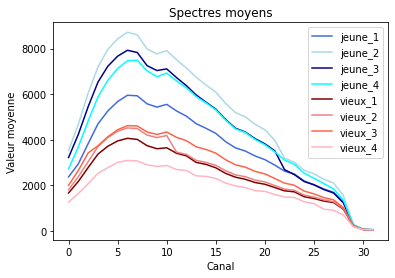

In [131]:
plt.plot(MEAN_SPECTRUM_J1, label="jeune_1", color='royalblue')
plt.plot(MEAN_SPECTRUM_J2, label="jeune_2", color='lightblue')
plt.plot(MEAN_SPECTRUM_J3, label="jeune_3", color='darkblue')
plt.plot(MEAN_SPECTRUM_J4, label="jeune_4", color='cyan')
plt.plot(MEAN_SPECTRUM_V1, label="vieux_1", color='maroon')
plt.plot(MEAN_SPECTRUM_V2, label="vieux_2", color='lightcoral')
plt.plot(MEAN_SPECTRUM_V3, label="vieux_3", color='tomato')
plt.plot(MEAN_SPECTRUM_V4, label="vieux_4", color='lightpink')
plt.ylabel("Valeur moyenne")
plt.xlabel("Canal")
plt.title("Spectres moyens")
plt.legend()
plt.show()

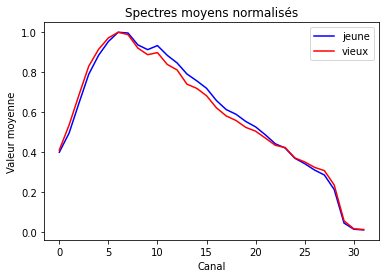

In [96]:
plt.plot(MEAN_SPECTRUM_J/max(MEAN_SPECTRUM_J), label="jeune", color='b')
plt.plot(MEAN_SPECTRUM_V/max(MEAN_SPECTRUM_V), label="vieux", color='r')
plt.ylabel("Valeur moyenne")
plt.xlabel("Canal")
plt.title("Spectres moyens normalisés")
plt.legend()
plt.show()

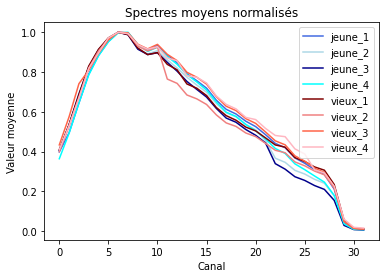

In [132]:
plt.plot(MEAN_SPECTRUM_J1/max(MEAN_SPECTRUM_J1), label="jeune_1", color='royalblue')
plt.plot(MEAN_SPECTRUM_J2/max(MEAN_SPECTRUM_J2), label="jeune_2", color='lightblue')
plt.plot(MEAN_SPECTRUM_J3/max(MEAN_SPECTRUM_J3), label="jeune_3", color='darkblue')
plt.plot(MEAN_SPECTRUM_J4/max(MEAN_SPECTRUM_J4), label="jeune_4", color='cyan')
plt.plot(MEAN_SPECTRUM_V1/max(MEAN_SPECTRUM_V1), label="vieux_1", color='maroon')
plt.plot(MEAN_SPECTRUM_V2/max(MEAN_SPECTRUM_V2), label="vieux_2", color='lightcoral')
plt.plot(MEAN_SPECTRUM_V3/max(MEAN_SPECTRUM_V3), label="vieux_3", color='tomato')
plt.plot(MEAN_SPECTRUM_V4/max(MEAN_SPECTRUM_V4), label="vieux_4", color='lightpink')
plt.ylabel("Valeur moyenne")
plt.xlabel("Canal")
plt.title("Spectres moyens normalisés")
plt.legend()
plt.show()

## 7. Autres...

In [ ]:
#Dictionnaire qui contient les fichiers des images originales
raw_images_names = {"j5_1_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_1_740nm.h5"),
                    "j5_2_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_2_740nm.h5"),
                    "j5_3_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_3_740nm.h5"),
                    "j5_4_740nm":os.path.join(path_dir, "j5-740nm/hdf5-images/j5_4_740nm.h5"),
                    "j5_1_780nm":os.path.join(path_dir, "j5-780nm/hdf5-images/j5_1_780nm.h5"),
                    "j5_2_780nm":os.path.join(path_dir, "j5-780nm/hdf5-images/j5_2_780nm.h5"),
                    "j5_3_780nm":os.path.join(path_dir, "j5-780nm/hdf5-images/j5_3_780nm.h5"),
                    "j5_4_780nm":os.path.join(path_dir, "j5-780nm/hdf5-images/j5_4_780nm.h5"),
                    "j5_1_820nm":os.path.join(path_dir, "j5-820nm/hdf5-images/j5_1_820nm.h5"),
                    "j5_2_820nm":os.path.join(path_dir, "j5-820nm/hdf5-images/j5_2_820nm.h5"),
                    "j5_3_820nm":os.path.join(path_dir, "j5-820nm/hdf5-images/j5_3_820nm.h5"),
                    "j5_4_820nm":os.path.join(path_dir, "j5-820nm/hdf5-images/j5_4_820nm.h5"),
                    "v2_1_740nm":os.path.join(path_dir, "v2-740nm/hdf5-images/v2_1_740nm.h5"),
                    "v2_2_740nm":os.path.join(path_dir, "v2-740nm/hdf5-images/v2_2_740nm.h5"),
                    "v2_3_740nm":os.path.join(path_dir, "v2-740nm/hdf5-images/v2_3_740nm.h5"),
                    "v2_4_740nm":os.path.join(path_dir, "v2-740nm/hdf5-images/v2_4_740nm.h5"),
                    "v6_3_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_3_740nm.h5"),
                    "v6_4_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_4_740nm.h5"),
                    "v6_5_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_5_740nm.h5"),
                    "v6_6_740nm":os.path.join(path_dir, "v6-740nm/hdf5-images/v6_6_740nm.h5"),
                    "v6_3_780nm":os.path.join(path_dir, "v6-780nm/hdf5-images/v6_3_780nm.h5"),
                    "v6_4_780nm":os.path.join(path_dir, "v6-780nm/hdf5-images/v6_4_780nm.h5"),
                    "v6_5_780nm":os.path.join(path_dir, "v6-780nm/hdf5-images/v6_5_780nm.h5"),
                    "v6_6_780nm":os.path.join(path_dir, "v6-780nm/hdf5-images/v6_6_780nm.h5"),
                    "v6_3_820nm":os.path.join(path_dir, "v6-820nm/hdf5-images/v6_3_820nm.h5"),
                    "v6_4_820nm":os.path.join(path_dir, "v6-820nm/hdf5-images/v6_4_820nm.h5"),
                    "v6_5_820nm":os.path.join(path_dir, "v6-820nm/hdf5-images/v6_5_820nm.h5"),
                    "v6_6_820nm":os.path.join(path_dir, "v6-820nm/hdf5-images/v6_6_820nm.h5")}

In [ ]:
#Dictionnaire qui contient les fichiers des images après segmentation
segmented_images_names = {"j5_1_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_1_740nm_Simple-Segmentation.h5"),
                          "j5_2_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_2_740nm_Simple-Segmentation.h5"),
                          "j5_3_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_3_740nm_Simple-Segmentation.h5"),
                          "j5_4_740nm":os.path.join(path_dir, "j5-740nm/segmented-images/j5_4_740nm_Simple-Segmentation.h5"),
                          "j5_1_780nm":os.path.join(path_dir, "j5-780nm/segmented-images/j5_1_780nm_Simple-Segmentation.h5"),
                          "j5_2_780nm":os.path.join(path_dir, "j5-780nm/segmented-images/j5_2_780nm_Simple-Segmentation.h5"),
                          "j5_3_780nm":os.path.join(path_dir, "j5-780nm/segmented-images/j5_3_780nm_Simple-Segmentation.h5"),
                          "j5_4_780nm":os.path.join(path_dir, "j5-780nm/segmented-images/j5_4_780nm_Simple-Segmentation.h5"),
                          "j5_1_820nm":os.path.join(path_dir, "j5-820nm/segmented-images/j5_1_820nm_Simple-Segmentation.h5"),
                          "j5_2_820nm":os.path.join(path_dir, "j5-820nm/segmented-images/j5_2_820nm_Simple-Segmentation.h5"),
                          "j5_3_820nm":os.path.join(path_dir, "j5-820nm/segmented-images/j5_3_820nm_Simple-Segmentation.h5"),
                          "j5_4_820nm":os.path.join(path_dir, "j5-820nm/segmented-images/j5_4_820nm_Simple-Segmentation.h5"),
                          "v2_1_740nm":os.path.join(path_dir, "v2-740nm/segmented-images/v2_1_740nm_Simple-Segmentation.h5"),
                          "v2_2_740nm":os.path.join(path_dir, "v2-740nm/segmented-images/v2_2_740nm_Simple-Segmentation.h5"),
                          "v2_3_740nm":os.path.join(path_dir, "v2-740nm/segmented-images/v2_3_740nm_Simple-Segmentation.h5"),
                          "v2_4_740nm":os.path.join(path_dir, "v2-740nm/segmented-images/v2_4_740nm_Simple-Segmentation.h5"),
                          "v6_3_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_3_740nm_Simple-Segmentation.h5"),
                          "v6_4_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_4_740nm_Simple-Segmentation.h5"),
                          "v6_5_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_5_740nm_Simple-Segmentation.h5"),
                          "v6_6_740nm":os.path.join(path_dir, "v6-740nm/segmented-images/v6_6_740nm_Simple-Segmentation.h5"),
                          "v6_3_780nm":os.path.join(path_dir, "v6-780nm/segmented-images/v6_3_780nm_Simple-Segmentation.h5"),
                          "v6_4_780nm":os.path.join(path_dir, "v6-780nm/segmented-images/v6_4_780nm_Simple-Segmentation.h5"),
                          "v6_5_780nm":os.path.join(path_dir, "v6-780nm/segmented-images/v6_5_780nm_Simple-Segmentation.h5"),
                          "v6_6_780nm":os.path.join(path_dir, "v6-780nm/segmented-images/v6_6_780nm_Simple-Segmentation.h5"),
                          "v6_3_820nm":os.path.join(path_dir, "v6-820nm/segmented-images/v6_3_820nm_Simple-Segmentation.h5"),
                          "v6_4_820nm":os.path.join(path_dir, "v6-820nm/segmented-images/v6_4_820nm_Simple-Segmentation.h5"),
                          "v6_5_820nm":os.path.join(path_dir, "v6-820nm/segmented-images/v6_5_820nm_Simple-Segmentation.h5"),
                          "v6_6_820nm":os.path.join(path_dir, "v6-820nm/segmented-images/v6_6_820nm_Simple-Segmentation.h5")}

In [ ]:
T = []
for name, img in raw_images.items():
  MS = Mean_spectrum(raw_images[name], segmented_images[name])
  T.append(MS)

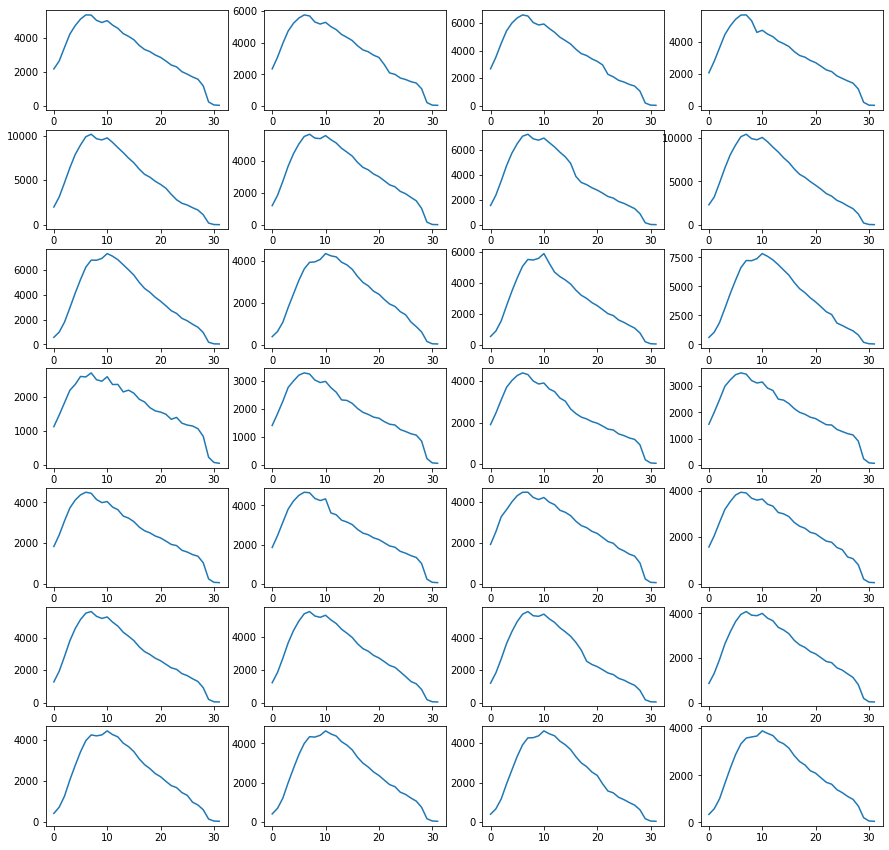

In [ ]:
c = 0
fig, axs = plt.subplots(7, 4, figsize=(15,15))
for i in range(7):
  for j in range(4):
    axs[i,j].plot(T[c])
    c+=1

In [ ]:
M = []
for i in range(28):
  M.append(np.mean(T[i]))

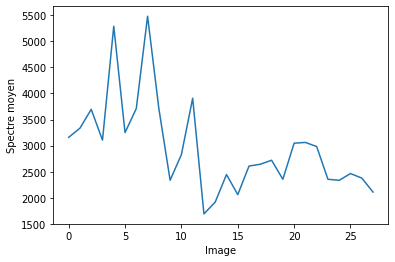

In [ ]:
plt.plot(M)
plt.xlabel("Image")
plt.ylabel("Spectre moyen")
plt.show()

## 6. Stockage

In [ ]:
Muscle = pd.DataFrame(columns=["Image", "Âge", "C00", "C01", "C02", "C03", "C04", "C05", "C06", "C07", "C08", "C09", "C10", "C11", "C12", "C13", "C14",
                               "C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31"])

## 6.1 Souris jeunes

## 6.2 Souris âgées

In [ ]:
AUX0 = np.copy(MEAN_SPECTRUM)
AUX = np.array(["j5_1_740nm", "Jeune"])
AUX = np.append(AUX, AUX0)
Df_aux = pd.Series(AUX, index = Muscle.columns)

In [ ]:
Muscle = Muscle.append(Df_aux, ignore_index=True)

In [ ]:
Muscle

,Image,Âge,C00,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31
0,j5_1_740nm,Jeune,2173.524010318712,2634.3712682420637,3425.23209131723,4202.452455292479,4694.930900496162,5074.954744507646,5318.67823613174,5309.326855781744,5001.528472257349,4877.456207551421,4986.915022371005,4727.20228477009,4538.631107575486,4232.871226090462,4070.4012265349697,3872.818124269053,3544.0682288816643,3307.0601434380687,3182.953617910292,2986.6278320128386,2847.9779370852857,2633.568148410425,2402.034231698924,2292.6129164769845,2013.791881448237,1870.553599210309,1705.8596259696785,1576.254445461192,1185.074928687154,252.25361009308605,74.72763321055722,55.25420481386619


## Annexes : Tests code

In [ ]:
def test(dset) :
  if (dset[0][z][y][x][0]==1)
#MEAN_CHANNELS[c] += dset[0][z][y][x][c]
#def sqrt_func(i, j):
    #time.sleep(1)
    #return math.sqrt(i**j)

#Parallel(n_jobs=2)(delayed(sqrt_func)(i, j) for i in range(5) for j in range(2))


SyntaxError: ignored